# Build MI Network from types and samples

Gather all the annots for the datasets, then group the mby cells and samples to build a MI inference networks of cell types.

Also different layout plots of the netowrk for different stages and clusterings.

## Libs and constants

In [1]:
import os
import scanpy as sc
from itertools import compress
import pandas as pd
import numpy as np
os.chdir('/root/host_home/luca/')

In [30]:
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries/'
atlas_dir = '/root/datos/maestria/netopaas/luca/data/atlas/'
# The atlas with only tumor primary tissues and uicc stage annotated
id_ = 'extended_tumor_hvg'
cell_type_key = 'cell_type_adjusted'
sample_key = 'sample'
dataset_key = 'dataset'
time = 'I-II_leidenwu'
annot_suffix = '_wu'
time_solo = time.split('_')[0]
time_suffix = 'early' if time_solo == 'I-II' else 'late'
aracne_dir = 'outputARACNE'
subc_dir = 'Subcluster_wu'

## Concatenate

We import all the annotations from the LUCA dataset an then add the annotations from te other datasets incrementally.
The time variable chooses the subset of time to build netowrks for specific subsets of time.

You must bear this in mind when adding a new dataset.

### Atlas dataset

In [31]:
import h5py
from anndata.experimental import read_elem

with h5py.File(f'{atlas_dir}/{id_}.h5ad', 'r') as f:
  # Check if 'obs' group exists (common for scRNA-seq data)
  if 'obs' in f:
    obs_matrix = read_elem(f['obs'])
  else:
    # Handle the case where 'obs' is not present
    print("obs matrix not found in the h5ad file.")

leiden = pd.read_csv(f'{backup_dir}/{subc_dir}/Atlas_predicted_leiden_{time_suffix}.csv', index_col=0)

obs_matrix.loc[leiden.index, cell_type_key] = leiden[cell_type_key]

if 'I-II' in time:
    stages = ['I', 'II']
else:
    stages = ['III', 'III or IV', 'IV']
obs_matrix = obs_matrix[obs_matrix['uicc_stage'].isin(stages)]

# Check that all the tumor cells are reassigned!
assert not any(['Tumor cell' in ct for ct in obs_matrix[cell_type_key].unique()])

# Remove unused categories for all categorical columns in obs
for col in obs_matrix.select_dtypes(['category']).columns:
    obs_matrix[col] = obs_matrix[col].cat.remove_unused_categories()

obs_matrix

,sample,uicc_stage,ever_smoker,age,donor_id,origin,dataset,ann_fine,cell_type_predicted,doublet_status,...,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,cell_type_adjusted
AAACCTGAGAGGTAGA-1_1-1,Chen_Zhang_2020_NSCLC-3,I,NaN,NaN,Chen_Zhang_2020_NSCLC-3,tumor_primary,Chen_Zhang_2020,T cell CD4,T cell CD4,singlet,...,"CD4-positive, alpha-beta T cell",10x 3' v2,non-small cell lung carcinoma,Homo sapiens,male,lung,unknown,unknown,!=mH!8xmT+,T cell CD4
AAACCTGAGATCCTGT-1_1-1,Chen_Zhang_2020_NSCLC-3,I,NaN,NaN,Chen_Zhang_2020_NSCLC-3,tumor_primary,Chen_Zhang_2020,T cell regulatory,T cell CD4,singlet,...,regulatory T cell,10x 3' v2,non-small cell lung carcinoma,Homo sapiens,male,lung,unknown,unknown,6C9%zMK<#!,T cell regulatory
AAACCTGAGGAGCGAG-1_1-1,Chen_Zhang_2020_NSCLC-3,I,NaN,NaN,Chen_Zhang_2020_NSCLC-3,tumor_primary,Chen_Zhang_2020,T cell regulatory,T cell CD4,singlet,...,regulatory T cell,10x 3' v2,non-small cell lung carcinoma,Homo sapiens,male,lung,unknown,unknown,=M>XfR(O4E,T cell regulatory
AAACCTGAGGCCATAG-1_1-1,Chen_Zhang_2020_NSCLC-3,I,NaN,NaN,Chen_Zhang_2020_NSCLC-3,tumor_primary,Chen_Zhang_2020,T cell CD4,T cell CD4,singlet,...,"CD4-positive, alpha-beta T cell",10x 3' v2,non-small cell lung carcinoma,Homo sapiens,male,lung,unknown,unknown,o$Ku5#5(L*,T cell CD4
AAACCTGAGGTTCCTA-1_1-1,Chen_Zhang_2020_NSCLC-3,I,NaN,NaN,Chen_Zhang_2020_NSCLC-3,tumor_primary,Chen_Zhang_2020,T cell CD8 activated,T cell CD4,singlet,...,"CD8-positive, alpha-beta T cell",10x 3' v2,non-small cell lung carcinoma,Homo sapiens,male,lung,unknown,unknown,fxBZ(PN(6e,T cell CD8 activated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811511_27-3,UKIM-V-2_P17_tumor_primary,I,yes,60.0,UKIM-V-2_P17,tumor_primary,UKIM-V-2,Neutrophils,NaN,singlet,...,neutrophil,BD Rhapsody Whole Transcriptome Analysis,squamous cell lung carcinoma,Homo sapiens,female,lung,unknown,60-year-old human stage,3(g6vJNO@o,Neutrophils
468397_27-3,UKIM-V-2_P17_tumor_primary,I,yes,60.0,UKIM-V-2_P17,tumor_primary,UKIM-V-2,Neutrophils,NaN,singlet,...,neutrophil,BD Rhapsody Whole Transcriptome Analysis,squamous cell lung carcinoma,Homo sapiens,female,lung,unknown,60-year-old human stage,jR%lZ``FtE,Neutrophils
115884_27-3,UKIM-V-2_P17_tumor_primary,I,yes,60.0,UKIM-V-2_P17,tumor_primary,UKIM-V-2,Neutrophils,NaN,singlet,...,neutrophil,BD Rhapsody Whole Transcriptome Analysis,squamous cell lung carcinoma,Homo sapiens,female,lung,unknown,60-year-old human stage,HsX>>5FRv|,Neutrophils
201201_27-3,UKIM-V-2_P17_tumor_primary,I,yes,60.0,UKIM-V-2_P17,tumor_primary,UKIM-V-2,Neutrophils,NaN,singlet,...,neutrophil,BD Rhapsody Whole Transcriptome Analysis,squamous cell lung carcinoma,Homo sapiens,female,lung,unknown,60-year-old human stage,BV1<+6rUgg,Neutrophils


We need this to attach dataset later

In [32]:
lol = obs_matrix.groupby(['uicc_stage','sample', 'dataset']).first().dropna(how='all').reset_index()
lol.groupby(['uicc_stage','dataset']).count().loc[:,['sample']]['sample'].sum()

/tmp/ipykernel_2802079/3864733082.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lol = obs_matrix.groupby(['uicc_stage','sample', 'dataset']).first().dropna(how='all').reset_index()
/tmp/ipykernel_2802079/3864733082.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lol.groupby(['uicc_stage','dataset']).count().loc[:,['sample']]['sample'].sum()


68

In [33]:
groups = obs_matrix.groupby([cell_type_key, sample_key]).size()
groups = groups.reset_index()
groups = pd.merge(groups, lol.loc[:,['dataset','sample']], on='sample')
groups

/tmp/ipykernel_2802079/2855531235.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = obs_matrix.groupby([cell_type_key, sample_key]).size()


,cell_type_adjusted,sample,0,dataset
0,B cell,Chen_Zhang_2020_NSCLC-1,771,Chen_Zhang_2020
1,B cell,Chen_Zhang_2020_NSCLC-2,552,Chen_Zhang_2020
2,B cell,Chen_Zhang_2020_NSCLC-3,774,Chen_Zhang_2020
3,B cell,Chen_Zhang_2020_NSCLC-6,119,Chen_Zhang_2020
4,B cell,Chen_Zhang_2020_NSCLC-7,1841,Chen_Zhang_2020
...,...,...,...,...
3327,stromal dividing,Zilionis_Klein_2019_p4t1,0,Zilionis_Klein_2019
3328,stromal dividing,Zilionis_Klein_2019_p4t2,0,Zilionis_Klein_2019
3329,stromal dividing,Zilionis_Klein_2019_p4t3,0,Zilionis_Klein_2019
3330,stromal dividing,Zilionis_Klein_2019_p6t1,0,Zilionis_Klein_2019


In [34]:
# It is less beacause we remove endothelial
# groups = pd.read_csv(f'{backup_dir}/Group_checks/groups_{time}_Atlas.csv', index_col=0)
groups.to_csv(f'{backup_dir}/Group_checks/groups_{time_solo}_Atlas.csv')
groups.cell_type_adjusted.unique()

array(['B cell', 'B cell dividing', 'Ciliated', 'Club_AT2/1_high',
       'DC mature', 'Endothelial cell arterial',
       'Endothelial cell capillary', 'Endothelial cell lymphatic',
       'Endothelial cell venous', 'Fibroblast adventitial',
       'Fibroblast alveolar', 'Fibroblast peribronchial', 'Macrophage',
       'Macrophage alveolar', 'Mast cell', 'Mesothelial',
       'Monocyte classical', 'Monocyte non-classical', 'NK cell',
       'NK cell dividing', 'Neutrophils', 'Pericyte', 'Plasma cell',
       'Plasma cell dividing', 'Smooth muscle cell', 'T cell CD4',
       'T cell CD4 dividing', 'T cell CD8 activated',
       'T cell CD8 dividing', 'T cell CD8 effector memory',
       'T cell CD8 naive', 'T cell CD8 terminally exhausted',
       'T cell NK-like', 'T cell regulatory', 'Tumor Club_AT2_LUAD',
       'Tumor LUAD', 'Tumor LUAD_AT1/2', 'Tumor LUAD_Club_AT2',
       'Tumor LUAD_Club_AT2/1', 'Tumor LUAD_MSLN', 'Tumor LUAD_NE_LUSC',
       'Tumor LUAD_NE_mitotic', 'Tumor LUAD

In [35]:
len(groups['sample'].unique())

68

### Add Deng Annots

In [36]:
new_annots = pd.read_csv(f'{backup_dir}/Deng{annot_suffix}_predicted.csv', index_col=0)

leiden = pd.read_csv(f'{backup_dir}/{subc_dir}/Deng_predicted_leiden_{time_suffix}.csv', index_col=0)
new_annots.loc[leiden.index, cell_type_key] = leiden[cell_type_key]

if 'I-II' in time:
    stages = ['IA1', 'IB', 'IA2', 'IA3', 'IIB']
else:
    stages = ['IIIA', 'IIIB']

# print(stages)
new_annots = new_annots[new_annots['Pathological stage'].isin(stages)]

# Check that all the tumor cells are reassigned!
assert not any(['Tumor cell' in ct for ct in new_annots[cell_type_key].unique()])


# Remove unused categories for all categorical columns in obs
for col in new_annots.select_dtypes(['category']).columns:
    new_annots[col] = new_annots[col].cat.remove_unused_categories()

print(new_annots['sample'].unique())

new_groups = new_annots.groupby([cell_type_key, sample_key]).size()
new_groups = new_groups.reset_index()
new_groups.columns = [cell_type_key, sample_key, '0']
new_groups
new_groups['dataset'] = 'Deng'
print(len(new_groups['sample'].unique()))
# new_groups['sample'].value_counts()
# new_groups.set_index([cell_type_key,sample_key], inplace=True)

['P001' 'P002' 'P003' 'P004' 'P005' 'P006' 'P007' 'P008' 'P009' 'P010'
 'P011' 'P012' 'P013' 'P014' 'P015' 'P016' 'P017' 'P018' 'P019' 'P020'
 'P021' 'P022' 'P023' 'P024' 'P025' 'P026' 'P027' 'P028' 'P029' 'P030'
 'P031' 'P032' 'P033' 'P034' 'P035' 'P036' 'P037' 'P038' 'P039' 'P040'
 'P041' 'P042' 'P043']
43


MERGE THEM!

In [37]:
groups_atlas = groups.copy()
groups_atlas.columns = [cell_type_key, sample_key, '0', 'dataset']
groups = pd.concat([groups_atlas, new_groups])
groups.cell_type_adjusted.unique()

array(['B cell', 'B cell dividing', 'Ciliated', 'Club_AT2/1_high',
       'DC mature', 'Endothelial cell arterial',
       'Endothelial cell capillary', 'Endothelial cell lymphatic',
       'Endothelial cell venous', 'Fibroblast adventitial',
       'Fibroblast alveolar', 'Fibroblast peribronchial', 'Macrophage',
       'Macrophage alveolar', 'Mast cell', 'Mesothelial',
       'Monocyte classical', 'Monocyte non-classical', 'NK cell',
       'NK cell dividing', 'Neutrophils', 'Pericyte', 'Plasma cell',
       'Plasma cell dividing', 'Smooth muscle cell', 'T cell CD4',
       'T cell CD4 dividing', 'T cell CD8 activated',
       'T cell CD8 dividing', 'T cell CD8 effector memory',
       'T cell CD8 naive', 'T cell CD8 terminally exhausted',
       'T cell NK-like', 'T cell regulatory', 'Tumor Club_AT2_LUAD',
       'Tumor LUAD', 'Tumor LUAD_AT1/2', 'Tumor LUAD_Club_AT2',
       'Tumor LUAD_Club_AT2/1', 'Tumor LUAD_MSLN', 'Tumor LUAD_NE_LUSC',
       'Tumor LUAD_NE_mitotic', 'Tumor LUAD

In [38]:
# groups = pd.read_csv(f'{backup_dir}/Group_checks/groups_{time_solo}_deng.csv', index_col=0)
groups.to_csv(f'{backup_dir}/Group_checks/groups_{time_solo}_deng.csv')

In [39]:
len(groups.reset_index()['sample'].unique())

111

### Add Hu Annots

In [40]:
new_annots = pd.read_csv(f'{backup_dir}/Hu{annot_suffix}_predicted.csv')
print(len(new_groups['sample'].unique()))
new_annots['sample'].unique()
new_annots

43


,index,Sample,Patient,Resource,Sex,Age,Clinical Stage,Pathology,PD1 Antibody,Chemotherapy,...,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,cell_type_tumor,dataset2,sample,_scvi_batch,_scvi_labels
0,Hu_BD_immune01_612637,BD_immune01,P01,Pre-treatment biopsy,Male,68.0,IIIA,Squamous,Toripalimab,Carboplatin+Docetaxel,...,36.828238,50.973347,3062.0,8.027150,6.667538,Tumor cells LUSC mitotic,Hu,BD_immune01,53,51
1,Hu_BD_immune01_698718,BD_immune01,P01,Pre-treatment biopsy,Male,68.0,IIIA,Squamous,Toripalimab,Carboplatin+Docetaxel,...,34.859121,48.927782,1768.0,7.478170,4.250409,Tumor cells LUSC mitotic,Hu,BD_immune01,53,51
2,Hu_BD_immune01_509246,BD_immune01,P01,Pre-treatment biopsy,Male,68.0,IIIA,Squamous,Toripalimab,Carboplatin+Docetaxel,...,41.040680,53.690054,5425.0,8.598957,17.015339,Tumor cells LUSC mitotic,Hu,BD_immune01,53,51
3,Hu_BD_immune01_101435,BD_immune01,P01,Pre-treatment biopsy,Male,68.0,IIIA,Squamous,Toripalimab,Carboplatin+Docetaxel,...,33.784729,48.175345,2198.0,7.695758,6.987094,Tumor cells LUSC mitotic,Hu,BD_immune01,53,51
4,Hu_BD_immune01_400370,BD_immune01,P01,Pre-treatment biopsy,Male,68.0,IIIA,Squamous,Toripalimab,Carboplatin+Docetaxel,...,45.389427,59.927361,1073.0,6.979145,10.825262,T cell CD8 dividing,Hu,BD_immune01,53,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92325,Hu_BD_immune13_111313,BD_immune13,P13,Post-treatment surgery,Male,59.0,IIIA,Squamous,Sintilimab,Carboplatin+Gemcitabine,...,43.041798,57.267299,1400.0,7.244942,9.834914,T cell CD8 dividing,Hu,BD_immune13,53,51
92326,Hu_BD_immune13_791956,BD_immune13,P13,Post-treatment surgery,Male,59.0,IIIA,Squamous,Sintilimab,Carboplatin+Gemcitabine,...,41.201106,55.827736,1075.0,6.981006,8.494666,T cell CD4 dividing,Hu,BD_immune13,53,51
92327,Hu_BD_immune14_462072,BD_immune14,P14,Post-treatment surgery,Male,79.0,IIIA,Squamous,Sintilimab,Carboplatin+Gemcitabine,...,40.040022,55.512098,1039.0,6.946976,9.450609,B cell dividing,Hu,BD_immune14,53,51
92328,Hu_BD_immune14_124095,BD_immune14,P14,Post-treatment surgery,Male,79.0,IIIA,Squamous,Sintilimab,Carboplatin+Gemcitabine,...,39.452055,54.904110,823.0,6.714170,11.273972,T cell CD4 dividing,Hu,BD_immune14,53,51


In [41]:
leiden = pd.read_csv(f'{backup_dir}/{subc_dir}/Hu_predicted_leiden_{time_suffix}.csv')
new_annots.loc[leiden.index, cell_type_key] = leiden[cell_type_key]

if 'I-II' in time:
    stages = ['IA1', 'IB', 'IA2', 'IA3', 'IIB']
else:
    stages = ['IIIA', 'IIIB']

# print(stages)
new_annots = new_annots[new_annots['Clinical Stage'].isin(stages)]

# Check that all the tumor cells are reassigned!
assert not any(['Tumor cell' in ct for ct in new_annots[cell_type_key].unique()])

# Remove unused categories for all categorical columns in obs
for col in new_annots.select_dtypes(['category']).columns:
    new_annots[col] = new_annots[col].cat.remove_unused_categories()


new_groups = new_annots.groupby([cell_type_key, sample_key]).size()
new_groups = new_groups.reset_index()
new_groups.columns = [cell_type_key, sample_key, '0']
new_groups['dataset'] = 'Hu'
new_groups
# print(len(new_groups['sample'].unique()))
# new_groups['sample'].value_counts()
# new_groups.set_index([cell_type_key,sample_key], inplace=True)

,cell_type_adjusted,sample,0,dataset


MERGE THEM!

In [42]:
groups_atlas = groups.copy()
groups_atlas.columns = [cell_type_key, sample_key, '0', 'dataset']
groups = pd.concat([groups_atlas, new_groups])
groups.cell_type_adjusted.unique()

array(['B cell', 'B cell dividing', 'Ciliated', 'Club_AT2/1_high',
       'DC mature', 'Endothelial cell arterial',
       'Endothelial cell capillary', 'Endothelial cell lymphatic',
       'Endothelial cell venous', 'Fibroblast adventitial',
       'Fibroblast alveolar', 'Fibroblast peribronchial', 'Macrophage',
       'Macrophage alveolar', 'Mast cell', 'Mesothelial',
       'Monocyte classical', 'Monocyte non-classical', 'NK cell',
       'NK cell dividing', 'Neutrophils', 'Pericyte', 'Plasma cell',
       'Plasma cell dividing', 'Smooth muscle cell', 'T cell CD4',
       'T cell CD4 dividing', 'T cell CD8 activated',
       'T cell CD8 dividing', 'T cell CD8 effector memory',
       'T cell CD8 naive', 'T cell CD8 terminally exhausted',
       'T cell NK-like', 'T cell regulatory', 'Tumor Club_AT2_LUAD',
       'Tumor LUAD', 'Tumor LUAD_AT1/2', 'Tumor LUAD_Club_AT2',
       'Tumor LUAD_Club_AT2/1', 'Tumor LUAD_MSLN', 'Tumor LUAD_NE_LUSC',
       'Tumor LUAD_NE_mitotic', 'Tumor LUAD

In [43]:
# groups = pd.read_csv(f'{backup_dir}/Group_checks/groups_{time_solo}_hu.csv', index_col=0)
groups.to_csv(f'{backup_dir}/Group_checks/groups_{time_solo}_hu.csv')

In [44]:
len(groups.reset_index()['sample'].unique())

111

### Add Bishoff Annots

In [45]:
new_annots = pd.read_csv(f'{backup_dir}/Bishoff{annot_suffix}_predicted.csv')
print(len(new_groups['sample'].unique()))

0


In [46]:
leiden = pd.read_csv(f'{backup_dir}/{subc_dir}/Bishoff_predicted_leiden_{time_suffix}.csv')
new_annots.loc[leiden.index, cell_type_key] = leiden[cell_type_key]

# We only get late bishoff
if time_suffix == 'early':
    new_annots = new_annots[new_annots['tnm'].isin(['T1', 'T2'])]

# Check that all the tumor cells are reassigned!
assert not any(['Tumor cell' in ct for ct in new_annots[cell_type_key].unique()])

# Remove unused categories for all categorical columns in obs
for col in new_annots.select_dtypes(['category']).columns:
    new_annots[col] = new_annots[col].cat.remove_unused_categories()


new_groups = new_annots.groupby([cell_type_key, sample_key]).size()
new_groups = new_groups.reset_index()
new_groups.columns = [cell_type_key, sample_key, '0']
new_groups['dataset'] = 'Bishoff'
new_groups
# print(len(new_groups['sample'].unique()))
# new_groups['sample'].value_counts()
# new_groups.set_index([cell_type_key,sample_key], inplace=True)

,cell_type_adjusted,sample,0,dataset


MERGE THEM!

In [47]:
groups_atlas = groups.copy()
groups_atlas.columns = [cell_type_key, sample_key, '0', 'dataset']
groups = pd.concat([groups_atlas, new_groups])
groups.cell_type_adjusted.unique()

array(['B cell', 'B cell dividing', 'Ciliated', 'Club_AT2/1_high',
       'DC mature', 'Endothelial cell arterial',
       'Endothelial cell capillary', 'Endothelial cell lymphatic',
       'Endothelial cell venous', 'Fibroblast adventitial',
       'Fibroblast alveolar', 'Fibroblast peribronchial', 'Macrophage',
       'Macrophage alveolar', 'Mast cell', 'Mesothelial',
       'Monocyte classical', 'Monocyte non-classical', 'NK cell',
       'NK cell dividing', 'Neutrophils', 'Pericyte', 'Plasma cell',
       'Plasma cell dividing', 'Smooth muscle cell', 'T cell CD4',
       'T cell CD4 dividing', 'T cell CD8 activated',
       'T cell CD8 dividing', 'T cell CD8 effector memory',
       'T cell CD8 naive', 'T cell CD8 terminally exhausted',
       'T cell NK-like', 'T cell regulatory', 'Tumor Club_AT2_LUAD',
       'Tumor LUAD', 'Tumor LUAD_AT1/2', 'Tumor LUAD_Club_AT2',
       'Tumor LUAD_Club_AT2/1', 'Tumor LUAD_MSLN', 'Tumor LUAD_NE_LUSC',
       'Tumor LUAD_NE_mitotic', 'Tumor LUAD

In [48]:
# groups = pd.read_csv(f'{backup_dir}/Group_checks/groups_{time_solo}_bishoff.csv', index_col=0)
groups.to_csv(f'{backup_dir}/Group_checks/groups_{time_solo}_bishoff.csv')

In [49]:
len(groups.reset_index()['sample'].unique())

111

### Add Zuani Annots

In [50]:
new_annots = pd.read_csv(f'{backup_dir}/Zuani{annot_suffix}_predicted.csv', index_col=0)
print(new_annots['sample'].unique())
# wE SHOULD TAKE CARE THAT OUR INIDCES FOR CELLS ARE ALWAYS THE SAME
# new_annots.index = new_annots.index.str.split('_').str[1:].str.join('_') + '_' + new_annots['sample']
new_annots

['P16_T2' 'P17_T3' 'P18_T2' 'P19_T2' 'P21_T1' 'P17_T2' 'P21_T2' 'P22_T1'
 'P8_T2' 'P23_T1' 'P15_T2' 'P24_T1' 'P20_T2']


,sample,barcode,Source Name,Characteristics[tumor grading],stage,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mito,pct_counts_mito,cell_type_tumor,dataset2,_scvi_batch,_scvi_labels
index,,,,,,,,,,,,,,,
Zuani_AAACCCAAGCAACTTC-1,P16_T2,AAACCCAAGCAACTTC-1,P16_T2,T2bN0M0,II,2498.0,1009,1009,2498.0,222.0,8.887110,T cell CD8 activated,Zuani,53,51
Zuani_AAACCCAAGCGCTTCG-1,P16_T2,AAACCCAAGCGCTTCG-1,P16_T2,T2bN0M0,II,1586.0,800,800,1586.0,182.0,11.475409,T cell CD8 activated,Zuani,53,51
Zuani_AAACCCAAGGCTAACG-1,P16_T2,AAACCCAAGGCTAACG-1,P16_T2,T2bN0M0,II,4772.0,1754,1754,4772.0,107.0,2.242246,T cell CD8 activated,Zuani,53,51
Zuani_AAACCCACATAGGTTC-1,P16_T2,AAACCCACATAGGTTC-1,P16_T2,T2bN0M0,II,5139.0,1662,1662,5139.0,119.0,2.315626,T cell CD4,Zuani,53,51
Zuani_AAACCCACATCCTTGC-1,P16_T2,AAACCCACATCCTTGC-1,P16_T2,T2bN0M0,II,1666.0,713,713,1666.0,164.0,9.843937,T cell CD8 activated,Zuani,53,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zuani_TTTGATCAGTTGAATG-1,P20_T2,TTTGATCAGTTGAATG-1,P20_T2,T4N2M0,III,28995.0,2657,2657,28995.0,499.0,1.720986,Plasma cell,Zuani,53,51
Zuani_TTTGATCGTCAGCTTA-1,P20_T2,TTTGATCGTCAGCTTA-1,P20_T2,T4N2M0,III,8029.0,2397,2397,8029.0,250.0,3.113713,Monocyte classical,Zuani,53,51
Zuani_TTTGGAGGTCACCCTT-1,P20_T2,TTTGGAGGTCACCCTT-1,P20_T2,T4N2M0,III,26494.0,5149,5149,26494.0,948.0,3.578169,transitional club/AT2,Zuani,53,51


In [51]:
leiden = pd.read_csv(f'{backup_dir}/{subc_dir}/Zuani_predicted_leiden_{time_suffix}.csv', index_col=0)
new_annots.loc[leiden.index, cell_type_key] = leiden[cell_type_key]

if 'I-II' in time:
    stages = ['I','II']
else:
    stages = ['III']

print(stages)
new_annots = new_annots[new_annots['stage'].isin(stages)]

# Check that all the tumor cells are reassigned!
assert not any(['Tumor cell' in ct for ct in new_annots[cell_type_key].unique()])

# Remove unused categories for all categorical columns in obs
for col in new_annots.select_dtypes(['category']).columns:
    new_annots[col] = new_annots[col].cat.remove_unused_categories()

new_groups = new_annots.groupby([cell_type_key, sample_key]).size()
new_groups = new_groups.reset_index()
new_groups.columns = [cell_type_key, sample_key, '0']
new_groups['dataset'] = 'Zuani'
print(len(new_groups['sample'].unique()))
new_groups['sample'].value_counts()
# new_groups.set_index([cell_type_key,sample_key], inplace=True)

['I', 'II']
11


sample
P8_T2     44
P18_T2    41
P24_T1    40
P17_T2    38
P19_T2    38
P17_T3    37
P22_T1    34
P15_T2    33
P21_T2    31
P21_T1    27
P16_T2    22
Name: count, dtype: int64

MERGE THEM!

In [52]:
groups_atlas = groups.copy()
groups_atlas.columns = [cell_type_key, sample_key, '0', 'dataset']
groups = pd.concat([groups_atlas, new_groups])
groups.cell_type_adjusted.unique()

array(['B cell', 'B cell dividing', 'Ciliated', 'Club_AT2/1_high',
       'DC mature', 'Endothelial cell arterial',
       'Endothelial cell capillary', 'Endothelial cell lymphatic',
       'Endothelial cell venous', 'Fibroblast adventitial',
       'Fibroblast alveolar', 'Fibroblast peribronchial', 'Macrophage',
       'Macrophage alveolar', 'Mast cell', 'Mesothelial',
       'Monocyte classical', 'Monocyte non-classical', 'NK cell',
       'NK cell dividing', 'Neutrophils', 'Pericyte', 'Plasma cell',
       'Plasma cell dividing', 'Smooth muscle cell', 'T cell CD4',
       'T cell CD4 dividing', 'T cell CD8 activated',
       'T cell CD8 dividing', 'T cell CD8 effector memory',
       'T cell CD8 naive', 'T cell CD8 terminally exhausted',
       'T cell NK-like', 'T cell regulatory', 'Tumor Club_AT2_LUAD',
       'Tumor LUAD', 'Tumor LUAD_AT1/2', 'Tumor LUAD_Club_AT2',
       'Tumor LUAD_Club_AT2/1', 'Tumor LUAD_MSLN', 'Tumor LUAD_NE_LUSC',
       'Tumor LUAD_NE_mitotic', 'Tumor LUAD

In [53]:
# groups = pd.read_csv(f'{backup_dir}/Group_checks/groups_{time_solo}_zuani.csv', index_col=0)
groups.to_csv(f'{backup_dir}/Group_checks/groups_{time_solo}_zuani.csv')

## Groupby Samples and cell types

### Save groups

In [54]:
groups.to_csv(f'metadata/groups_{time}.csv')
# groups = pd.read_csv(f'metadata/groups_{time}.csv', index_col=0)

### Samples by type

In [399]:
groups.cell_type_adjusted.unique()

array(['AT2', 'B cell', 'B cell dividing', 'Ciliated', 'DC mature',
       'Endothelial cell arterial', 'Endothelial cell capillary',
       'Endothelial cell lymphatic', 'Endothelial cell venous',
       'Fibroblast adventitial', 'Fibroblast alveolar',
       'Fibroblast peribronchial', 'Macrophage', 'Macrophage alveolar',
       'Mast cell', 'Mesothelial', 'Monocyte classical',
       'Monocyte non-classical', 'NK cell', 'NK cell dividing',
       'Neutrophils', 'Pericyte', 'Plasma cell', 'Plasma cell dividing',
       'Smooth muscle cell', 'T cell CD4', 'T cell CD4 dividing',
       'T cell CD8 activated', 'T cell CD8 dividing',
       'T cell CD8 effector memory', 'T cell CD8 naive',
       'T cell CD8 terminally exhausted', 'T cell NK-like',
       'T cell regulatory', 'Tumor AT2/1_LUAD', 'Tumor Club/AT2_MSLN',
       'Tumor LUAD2', 'Tumor LUAD_EMT', 'Tumor LUAD_LUSC_mitotic',
       'Tumor LUAD_MSLN_LUSC', 'Tumor LUAD_ROS1+', 'Tumor LUAD_mitotic',
       'Tumor LUSC', 'Tumor LUSC

In [400]:
groups.sort_values([cell_type_key, sample_key],inplace=True)
groups.set_index([cell_type_key,sample_key], inplace=True)
groups = groups.loc[:,['0']]
groups

0
cell_type_adjusted sample                     
AT2                Chen_Zhang_2020_NSCLC-10  0
                   Chen_Zhang_2020_NSCLC-4   0
                   Chen_Zhang_2020_NSCLC-5   0
                   Chen_Zhang_2020_NSCLC-8   0
                   Chen_Zhang_2020_NSCLC-9   0
...                                         ..
stromal dividing   Zilionis_Klein_2019_p3t3  0
                   Zilionis_Klein_2019_p5t1  0
                   Zilionis_Klein_2019_p5t2  0
                   Zilionis_Klein_2019_p7t1  0
                   Zilionis_Klein_2019_p7t2  0

[5308 rows x 1 columns]

#### Check the distribution of nans across samples.

In [401]:
naners = groups.unstack().isnull()
count_nans = []
much_nans = []

for col in naners.columns:
    counter = sum(naners[col])
    if counter > 6:
        much_nans.append(col)
    count_nans.append(counter)

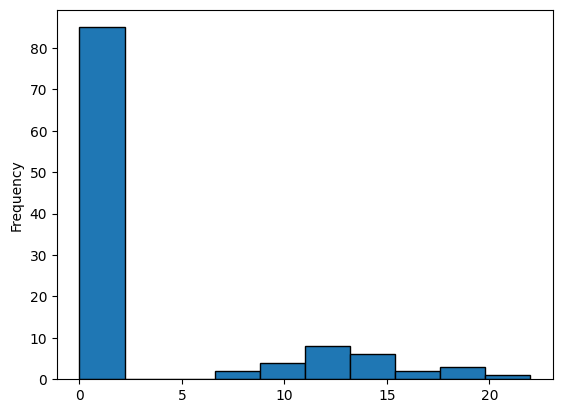

In [402]:
import matplotlib.pyplot as plt
data_series = pd.Series(count_nans)
data_series.plot(kind='hist', edgecolor='black')

plt.show()

Make a cutoff for only samples that have more than 1 cell of the type.

#### Cutoff

In [403]:
cutoff = pd.DataFrame(groups[groups > 1])
cell_present_samples = pd.DataFrame(cutoff.groupby(cell_type_key).size())

In [404]:
len(cutoff.reset_index()['sample'].unique())

111

### Cells by type

Aqui hay algo tenemos tipos celulares de cancer que no tienen nada de celulas. Estos osn
TUmor LUAd mainly 2, Tumor LUSC

In [405]:
cell_type_nums = cutoff.groupby(cell_type_key).sum()
cell_type_nums

,0
cell_type_adjusted,
AT2,19.0
B cell,23016.0
B cell dividing,209.0
Ciliated,2990.0
DC mature,466.0
Endothelial cell arterial,51.0
Endothelial cell capillary,184.0
Endothelial cell lymphatic,168.0
Endothelial cell venous,2206.0


### Total cells:

In [406]:
cutoff.groupby(cell_type_key).sum().sum()

0    368787.0
dtype: float64

This to compare as for whe we had all cels and grob annots

### Matrix of Samples by type

By the way the transfer of the labels is done in scArches, if the cluster is not present (*NA*) the label does not appear. So we replace NAs with 0s

In [407]:
samp_type = cutoff.unstack().transpose().fillna(0)
samp_type

cell_type_adjusted          AT2  B cell  B cell dividing  Ciliated  DC mature  \
  sample                                                                        
0 BD_immune01               0.0    36.0              0.0       0.0        0.0   
  BD_immune02               0.0  1881.0              2.0      11.0        0.0   
  BD_immune03               0.0   797.0             23.0       0.0        7.0   
  BD_immune04               0.0   428.0              0.0      13.0        6.0   
  BD_immune05               0.0   194.0              3.0       0.0        2.0   
...                         ...     ...              ...       ...        ...   
  Zilionis_Klein_2019_p7t1  0.0    39.0              0.0       0.0        3.0   
  Zilionis_Klein_2019_p7t2  0.0    37.0              0.0       0.0        6.0   
  p019t                     0.0    30.0              0.0      62.0        0.0   
  p030t                     0.0  1217.0              0.0      20.0        6.0   
  p033t                     0.0   374.0              0.0      51.0        4.0   

cell_type_adjusted          Endothelial cell arterial  \
  sample                                                
0 BD_immune01                                     0.0   
  BD_immune02                                     0.0   
  BD_immune03                                     0.0   
  BD_immune04                                     0.0   
  BD_immune05                                     0.0   
...                                               ...   
  Zilionis_Klein_2019_p7t1                        0.0   
  Zilionis_Klein_2019_p7t2                        0.0   
  p019t                                           0.0   
  p030t                                           0.0   
  p033t                                           0.0   

cell_type_adjusted          Endothelial cell capillary  \
  sample                                                 
0 BD_immune01                                      0.0   
  BD_immune02                                      0.0   
  BD_immune03                                      0.0   
  BD_immune04                                      0.0   
  BD_immune05                                      0.0   
...                                                ...   
  Zilionis_Klein_2019_p7t1                         0.0   
  Zilionis_Klein_2019_p7t2                         0.0   
  p019t                                            0.0   
  p030t                                            0.0   
  p033t                                            0.0   

cell_type_adjusted          Endothelial cell lymphatic  \
  sample                                                 
0 BD_immune01                                      0.0   
  BD_immune02                                      0.0   
  BD_immune03                                      0.0   
  BD_immune04                                      0.0   
  BD_immune05                                      0.0   
...                                                ...   
  Zilionis_Klein_2019_p7t1                         0.0   
  Zilionis_Klein_2019_p7t2                         0.0   
  p019t                                            0.0   
  p030t                                            9.0   
  p033t                                            2.0   

cell_type_adjusted          Endothelial cell venous  Fibroblast adventitial  \
  sample                                                                      
0 BD_immune01                                  12.0                     0.0   
  BD_immune02                                   2.0                     0.0   
  BD_immune03                                   4.0                     0.0   
  BD_immune04                                   5.0                     0.0   
  BD_immune05                                   3.0                     2.0   
...                                             ...                     ...   
  Zilionis_Klein_2019_p7t1                     16.0           

## Calculate MI with ARACNE AP

We decided to use Mutual Information (MI) as the metric of coabundance of our cells to be able to detect nonlinear patterns of coabundance.
This approach is not very common in the literature that focuses on the heterogeneity of cells in cancer tissue.

Essentially, MI captures how much information, in the probabilsitic sense, a variable $X$ gives about another variable $Y$. Where $X$ and $Y$ for us, would be the counts of some type of cells in in every sample.

It extracts the information by calculating the deviation of the product of marginal probabilites $P_{X}$ and $P_{Y}$,
(which would be the distribution if both variables were totally independent) from the mean of the joint probability $P_{X,Y}$ of all the observations (that is the actual empirical distribution).

The kind of deviation it uses is the Kullback-Leibler (KL) divergence, which is a concept from inferential statistics, that extracts the information (via logarithms) of this probability ratio.

Given two probability distributions P, Q , the KL divergence is the expectation of the logarithmic (hence information) difference between the probabilities P and Q,
 where the expectation is taken mutliplying by the probabilities P. So if we take the KL divergence from the joint and marginal probabilites we get the formula for the mutual information.

$$
I(X;Y) = \sum_{x,y}{ P_{X,Y}(x,y) \log{\frac{P_{X,Y}(x,y)}{P_X(x)P_Y(y)}}}
$$

This is actually also just this substraction of entropies:

$$
I(X;Y) = S(X) + S(Y) - S(X, Y)
$$

This measure is always positive and satisfies that it is zero if and only if the variables are statistically independent. Something that is not guaranteed with Pearson or Spearman correlation.

Now, how do we actually go about computing from our table of samples vs. cell types. We actually use an existing algorithm designed for gene coexpression networks named *ARACNE-AP*
that considers special properties like Data Processing Inequality, binning and statisitical significance. Its underlying assumptions are valid for our case also, and those are:

- That we consider only pairwise interactions.
- The variables follow the Data Processing Inequality, which helps assure that the interactions we discover are not due to indirect relationships.

ARACNE defines an edge as an irreducible statistical dependency between gene expression profiles that cannot be explained as an artifact of other statistical dependencies in the network.

The most basic case for discrete variables with repeated values can be visualized with a table:

|  T cell| Tumor |
|--------|-------|
| 100    | 10    |
| 200    | 10    |
| 100    | 10    |
| 300    | 20    |
| 300    | 20    |
| 400    | 30    |

To be able to calculate the sum of the MI, we can use a contingency table, which would give us the marginal probability in the margins and the joint in the inner cells.

So for example the marginal probability for 10 is $P_Y(10)=3/6$, where n=6 is the num observations and for the joint we have $P{X,Y}(A,10)=2/6$. Which leaves us with this table.

|    | 100 | 200 | 300| 400| tot |
|----|-----|-----|----|----|-----|
| 10 | 2   |  1  |  0 |  0 |  3  |
| 20 | 0   |  0  |  2 |  0 |  2  |
| 30 | 0   |  0  |  0 |  1 |  1  |
| tot| 2   | 1   |  2 |  1 |  6  |

We just plug in these values in the sum and we get the MI, which is 1.0113 nats, which is significant.

The problem is that our actual counts range from around 1 to 5k and our matrices are sparse, so, in our contingencies, we would just have 0's and 1's. Also, there are various errors that come from the technical measurement, to the data processing algorithms like gene alignment. That is, our supposed counts are in fact a range of values of counts and the best way to treat these ranges is as continous.

So instead of focusing on every point we will focus on densities of blocks of ranges of our data. This is achieved in our formula by considering log-probability densities, something that can only work with MI because, for continuous variables the entropy is infinite but the MI remains well defined.
It can be computed by replacing the entropy with the differential entropy, which averages the log-probability density rather than the log-mass.

So now we can work in blocks of densities, but how do we choose the right block size and what density do we choose for each of those blocks?
ARACNE builds on previous work by the lab of Califano, where ARACNE was first developed. At first they used Gaussian-Kernels with a fixed bandwidth,
but now the AP from ARACNE-AP comes from adatpive partitiong. This is because the space is split recursively into quadrants at the means (Fig. 1).
The stopping condition for the recursive procedure is met when a uniform distribution
(assessed by $\chi^2$ test) between the newly created quadrants is reached or fewer than
three data points fall into the quadrant to be split. (See figure below)

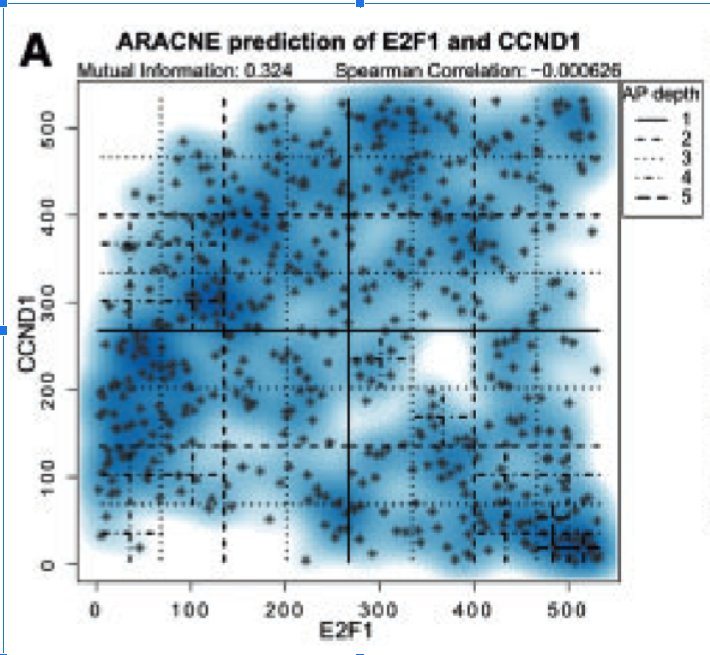



In that way we can now get the joint probability density for each of our blocks and if we sum over all the blocks we can then get an actual value for
the MI. But now to actually filter out the statistically significant values of our MI, we determine an MI threshold ($I_0$) by randomly shuffling all of our cell counts,
mutiple times, and empirically fitting a poisson distribution $ p(I > I_0) | I = 0) \propto \exp^{\alpha M I_0})$ to get our desired p-value.

We also have to use the Data Processing inequality that essentially says that if we have a trinagle of interactions, the least of them is very probable to come from the other two. And that gurantees that the interactions we obtain are not due to indirect effects.

In this way we can extract direct coabundances of cells in different tissue samples that can be correlated by nonlinear patterns and even more than one trend at a time. Like a downwards trend and an upwards trend at the same time like the figure above.



his decreases the influence of arbitrary transformations involved in microarray data preprocessing and removes the need to consider position-dependent kernel widths, h, which might be preferable for non-uniformly distributed data.

Thus the least of the three MIs can come from indirect
interactions only, and checking against the DPI may iden-
tify those gene pairs for which
φij = 0 even though
P(g i, g j) ≠ P(g i)P(g j). Correspondingly, ARACNE starts
with a network graph.

We export in a format that can be used for ARACNE AP, which has the 'genes' in the rows and only considers Target/TF pairs.
We repeat each type row because every type is a TF and a target.

In [408]:
aracne_dir = 'outputARACNE'

In [409]:
aracne_types = samp_type.transpose()

# Repeat to force ARACNE to consider types as target and TF.
aracne_types = pd.concat([aracne_types, aracne_types])

aracne_types.astype(int)
aracne_types.columns.name = None
aracne_types.index.name = 'types'
aracne_types

0                                                  \
sample           BD_immune01 BD_immune02 BD_immune03 BD_immune04 BD_immune05   
types                                                                          
AT2                      0.0         0.0         0.0         0.0         0.0   
B cell                  36.0      1881.0       797.0       428.0       194.0   
B cell dividing          0.0         2.0        23.0         0.0         3.0   
Ciliated                 0.0        11.0         0.0        13.0         0.0   
DC mature                0.0         0.0         7.0         6.0         2.0   
...                      ...         ...         ...         ...         ...   
cDC1                     0.0         0.0         5.0         0.0         0.0   
cDC2                     0.0        24.0        57.0        68.0         3.0   
myeloid dividing        23.0         5.0         8.0        31.0        13.0   
pDC                      0.0         5.0        31.0        21.0         0.0   
stromal dividing         0.0         0.0         0.0         0.0         0.0   

                                                                              \
sample           BD_immune06 BD_immune07 BD_immune08 BD_immune09 BD_immune10   
types                                                                          
AT2                      0.0         0.0         0.0         0.0         0.0   
B cell                  85.0        58.0       178.0       130.0        56.0   
B cell dividing          0.0         0.0         0.0         3.0         0.0   
Ciliated                 4.0         3.0         0.0         0.0         0.0   
DC mature                6.0        11.0        14.0         4.0         5.0   
...                      ...         ...         ...         ...         ...   
cDC1                     3.0         4.0         8.0         0.0         9.0   
cDC2                    51.0        54.0        52.0        10.0        27.0   
myeloid dividing        25.0        14.0        96.0        22.0        26.0   
pDC                     24.0        98.0        17.0        11.0        48.0   
stromal dividing         0.0        19.0         2.0         0.0         3.0   

                  ...                                                    \
sample            ... Zilionis_Klein_2019_p3t1 Zilionis_Klein_2019_p3t2   
types             ...                                                     
AT2               ...                      0.0                      0.0   
B cell            ...                    766.0                    888.0   
B cell dividing   ...                      0.0                      0.0   
Ciliated          ...                      4.0                      4.0   
DC mature         ...                      0.0                      2.0   
...               ...                      ...                      ...   
cDC1              ...                      4.0                      5.0   
cDC2              ...                     31.0                     43.0   
myeloid dividing  ...                      0.0                      0.0   
pDC               ...                      8.0                      4.0   
stromal dividing  ...                      0.0                      0.0   

                                                                    \
sample           Zilionis_Klein_2019_p3t3 Zilionis_Klein_2019_p5t1   
types                                                                
AT2                                   0.0                      0.0   
B cell                              724.0                     88.0   
B cell dividing                       0.0                      0.0   
Ciliated                              5.0                      4.0   
DC mature                             2.0                      0.0   
...                                   ...                      ...   
cDC1                                  5.0                      0.0   
cDC2                              

In [410]:
tfs = aracne_types.index[0:int(aracne_types.shape[0]/2)]

with open(f'{aracne_dir}/tfs{time}.txt', 'w') as f:
    for tf in tfs:
        f.write(str(tf) + '\n')

In [411]:
!cat {aracne_dir}/tfs{time}.txt

AT2
B cell
B cell dividing
Ciliated
DC mature
Endothelial cell arterial
Endothelial cell capillary
Endothelial cell lymphatic
Endothelial cell venous
Fibroblast adventitial
Fibroblast alveolar
Fibroblast peribronchial
Macrophage
Macrophage alveolar
Mast cell
Mesothelial
Monocyte classical
Monocyte non-classical
NK cell
NK cell dividing
Neutrophils
Pericyte
Plasma cell
Plasma cell dividing
Smooth muscle cell
T cell CD4
T cell CD4 dividing
T cell CD8 activated
T cell CD8 dividing
T cell CD8 effector memory
T cell CD8 naive
T cell CD8 terminally exhausted
T cell NK-like
T cell regulatory
Tumor AT2/1_LUAD
Tumor Club/AT2_MSLN
Tumor LUAD2
Tumor LUAD_EMT
Tumor LUAD_LUSC_mitotic
Tumor LUAD_MSLN_LUSC
Tumor LUAD_ROS1+
Tumor LUAD_mitotic
Tumor LUSC
Tumor LUSC_LUAD_NE
Tumor LUSC_mitotic_NE
Tumor NSCLC_mixed
cDC1
cDC2
myeloid dividing
pDC
stromal dividing


In [412]:
a = aracne_types.reset_index()
a.columns = a.columns.get_level_values('sample')
a = a.set_index([''])

In [413]:
a.to_csv(f'{aracne_dir}/matrix{time}.txt', sep='\t')

In [414]:
! head {aracne_dir}/matrix{time}.txt

	BD_immune01	BD_immune02	BD_immune03	BD_immune04	BD_immune05	BD_immune06	BD_immune07	BD_immune08	BD_immune09	BD_immune10	BD_immune11	BD_immune12	BD_immune13	BD_immune14	BD_immune15	Chen_Zhang_2020_NSCLC-10	Chen_Zhang_2020_NSCLC-4	Chen_Zhang_2020_NSCLC-5	Chen_Zhang_2020_NSCLC-8	Chen_Zhang_2020_NSCLC-9	Kim_Lee_2020_BRONCHO_58	Kim_Lee_2020_EBUS_06	Kim_Lee_2020_EBUS_28	Kim_Lee_2020_EBUS_49	Kim_Lee_2020_LUNG_T28	Kim_Lee_2020_LUNG_T31	Lambrechts_Thienpont_2018_6149v2_BT1290	Lambrechts_Thienpont_2018_6149v2_BT1291	Lambrechts_Thienpont_2018_6149v2_BT1292	Lambrechts_Thienpont_2018_6653_scrBT1430m	Lambrechts_Thienpont_2018_6653_scrBT1431m	Lambrechts_Thienpont_2018_6653_scrBT1432m	Laughney_Massague_2020_GSM3516665	Maynard_Bivona_2020_LT_S01	Maynard_Bivona_2020_LT_S11	Maynard_Bivona_2020_LT_S42	Maynard_Bivona_2020_LT_S52	Maynard_Bivona_2020_LT_S56	Maynard_Bivona_2020_LT_S57	Maynard_Bivona_2020_LT_S58	Maynard_Bivona_2020_LT_S67	Maynard_Bivona_2020_LT_S71	Maynard_Bivona_2020_LT_S74	Maynard_Bivona_20

We use [ARACNE-AP](https://github.com/califano-lab/ARACNe-AP/tree/master) because it is fast 
and we dont need many libraries. Just JAVA. Downlaod the git repo and change the path to that.

In [415]:
time

'III-IV_leidenwu'

First we must calculate the threshold

In [416]:
! java -Xmx5G -jar /root/host_home/ARACNe-AP/dist/aracne.jar -e {aracne_dir}/matrix{time}.txt  -o {aracne_dir} \
    --tfs {aracne_dir}/tfs{time}.txt --pvalue 1E-8 --seed 1 \
    --calculateThreshold

MI threshold file was already there, but I am recalculating it.
Finding threshold for 111 samples
Parameters for fitted threshold function: [0.20080405776592167, 6.22541231310148E-6]
MI threshold: 0.2279563498359055


In [417]:
%%time
%%bash -s {aracne_dir} {time}
echo $1
for i in {1..500}
do
java -Xmx5G -jar /root/host_home/ARACNe-AP/dist/aracne.jar -e $1/matrix$2.txt  -o $1 --tfs $1/tfs$2.txt --pvalue 1E-8 --seed $i
done


outputARACNE


Bootstrapping input matrix 1 with 102 genes and 111 samples
MI threshold file is present
Calculate network from: outputARACNE/matrixIII-IV_leidenwu.txt
TFs processed: 51
Time elapsed for calculating MI: 0 sec

DPI time elapsed: 0 sec
Edges removed by DPI:	131
Final Network size:	66
Total time elapsed: 0 sec
Bootstrapping input matrix 1 with 102 genes and 111 samples
MI threshold file is present
Calculate network from: outputARACNE/matrixIII-IV_leidenwu.txt
TFs processed: 51
Time elapsed for calculating MI: 0 sec

DPI time elapsed: 0 sec
Edges removed by DPI:	126
Final Network size:	82
Total time elapsed: 0 sec
Bootstrapping input matrix 1 with 102 genes and 111 samples
MI threshold file is present
Calculate network from: outputARACNE/matrixIII-IV_leidenwu.txt
TFs processed: 51
Time elapsed for calculating MI: 0 sec

DPI time elapsed: 0 sec
Edges removed by DPI:	153
Final Network size:	76
Total time elapsed: 0 sec
Bootstrapping input matrix 1 with 102 genes and 111 samples
MI threshold 

In [418]:
!java -Xmx5G -jar /root/host_home/ARACNe-AP/dist/aracne.jar -o {aracne_dir} --consolidate && rm {aracne_dir}/bootstrap*

Integrating 500 bootstraps...
bootstrapNetwork_l4p2t9hfverncrf8684hqmr7qk.txt
bootstrapNetwork_ift2tvkh9hlvkedn3pkd27unh2.txt
bootstrapNetwork_ukq2tnit5eoauv4u97u5jt34hr.txt
bootstrapNetwork_36mas798aeb42oal9mbscbl1cc.txt
bootstrapNetwork_4j4qtpg1fqhu2ogb0itbji9jng.txt
bootstrapNetwork_thhiu7m0654ob994dqfl6k1s3j.txt
bootstrapNetwork_h2aj10b3vmbanqlqo05eegi42c.txt
bootstrapNetwork_gvlevo1kp4i3703dlb22elfv91.txt
bootstrapNetwork_l16iudkrmq5tq817i5sh8n9t6g.txt
bootstrapNetwork_a6sb064ava9k4ialdf7t4hf26m.txt
bootstrapNetwork_tb5v26h8afi0c7mfq56l98kb2i.txt
bootstrapNetwork_77q6v9vgbagh0av8nhkphkv888.txt
bootstrapNetwork_bd3714b0tf1d24ht5idvqtc4ka.txt
bootstrapNetwork_7452u1k1kpn5fgcrcshdhpr3mt.txt
bootstrapNetwork_9s710cu07sqp66fffaj4hpllm.txt
bootstrapNetwork_ji86vru96ocs6rfu5ou4tsiq4h.txt
bootstrapNetwork_s68b1easck567n68c3korketqv.txt
bootstrapNetwork_69n24g9vj6t72oerc2ej26api.txt
bootstrapNetwork_dvcn12bb2ohj8e3dbum01cpa1p.txt
bootstrapNetwork_qr5n1ud85gcovfrvlqijb12r35.txt
bootstrapNet

Save with unique filename and removing first line for using for graphs

In [419]:
! sed '1d' {aracne_dir}/network.txt > {aracne_dir}/net{time}.txt

In [420]:
! cat {aracne_dir}/net{time}.txt

Monocyte classical	pDC	0.3769228153919178	0.0
Pericyte	Endothelial cell venous	0.3437356559106319	0.0
T cell CD4 dividing	myeloid dividing	0.29762049809768765	7.16340776363289E-7
Fibroblast peribronchial	Plasma cell	0.2949425400910914	0.0
Macrophage alveolar	Monocyte non-classical	0.2890027025887932	2.472703396483311E-7
T cell CD8 dividing	T cell regulatory	0.4839570270061211	0.0
Mast cell	T cell CD8 activated	0.45128379761037807	2.0355220766710147E-6
Fibroblast alveolar	Mast cell	0.2726234255204999	0.0
Fibroblast alveolar	Smooth muscle cell	0.29090696940669203	0.0
cDC2	pDC	0.3727508252193975	0.0
T cell CD8 activated	T cell CD4	0.5558850699644505	0.0
Pericyte	Fibroblast peribronchial	0.384652838418976	0.0
T cell CD4	Tumor AT2/1_LUAD	0.320784912093588	7.730371898162502E-12
T cell regulatory	Monocyte classical	0.4235996245308385	2.5856761176612508E-11
cDC2	Macrophage	0.4225326421932114	0.0
T cell CD4	B cell	0.6731488091488935	0.0
Mast cell	Macrophage	0.404770784758962	0.0
Mast cell	T cel